In [1]:
pwd()

"/home/bigcolin/Scripts/gplsim/quantile/qgplsim"

# Start

In [2]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("MonteCarloSIM.ji")
using Statistics, LinearAlgebra, Clustering
using LaTeXStrings, Plots

import Base.Threads.@threads

# QGPLSIM fitting

In [90]:
# run this ceil for different data sets

α = [2.0, 1.0] # single index for x
θ = [1.0, -2.0]  # linear for x, <α, θ> = 0 for identification
γ = [1.00, 0.5] # single index for z
β = [0.5, -1.0] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)

n = 600
fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 1 # 0 for gauss, 1 for Cauchy
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5

# Estimation 

model1 = qgplsim.model(X, Z, y, τ)
alpha_type = 1
# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for global: ∑ij sum(Bi - Bj) / n;
# 2 for local: ∑z ∑ij (bzi - bzj) * nz / n;
# when Z = 0, global == local
@time alpha, theta, gamma, beta = qgplsim.estimator(model1, alpha_type)
coefa = 1 #/ alpha[1]
coefg = 1 #/ gamma[1]
println("Estimation of index coefs: ")
println("̂α => ", coefa * alpha)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

# theta * alpha

 15.693523 seconds (4.62 M allocations: 17.051 GiB, 4.82% gc time)
Estimation of index coefs: 
̂α => [-0.9041933123114978, -0.42712346455230277]
̂γ => [-0.6746983350673871, -0.17318298792713357]
Estimation of linear coefs: 
̂θ => [0.9523957831367075 -2.0161615299887874]
̂β => [0.30961261208232305, -0.9380885470954459]


# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

In [4]:
using Plots
# include("qgplsim.ji")

In [91]:
alpha

2-element Array{Float64,1}:
 -0.9041933123114978
 -0.42712346455230277

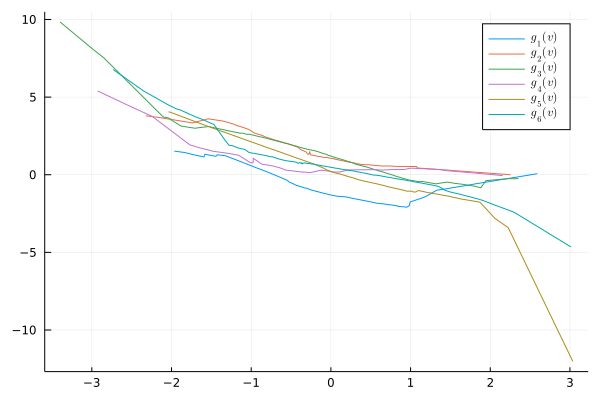

In [92]:
alphap = 1.0 * alpha
v = X * alphap # g(Xα + Zγ) => univar func. g(v + zγ) after α was determined and  Z = z
categ, index = model1.categ, model1.index
g, dg = qgplsim.Gz_DGz(v, Z, y, -0.2) # g: g(v), dg: g'(v)
fig = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]

    plot!(fig, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")

end
fig

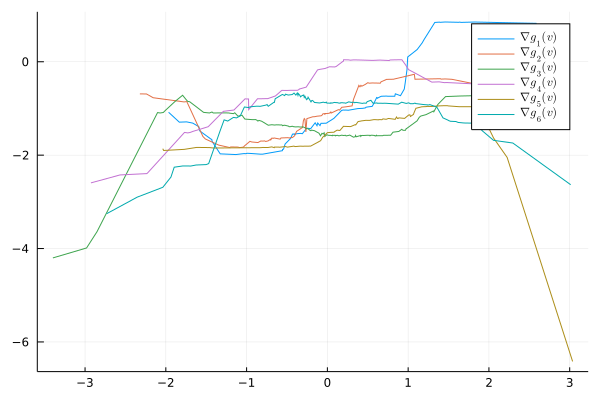

In [93]:
fig = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_vm = vm[indm]
    plot!(fig, sorted_vm, sorted_dgm, label = L"\nabla g_{%$m} (v)")

end
fig

# Monte Carlo Simulation

In [17]:
Threads.nthreads()

12

In [18]:
include("MonteCarloSIM.ji")

main (generic function with 4 methods)

In [94]:
α = [2.0, 1.0] # single index for x
θ = [1.0, -2.0]  # linear for x, <α, θ> = 0 for identification
γ = [1.0, 4.0] # single index for z
β = [1.0, -0.5] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 300
fx = 1
dist = 1 # Cauchy
len = 200 # MC rept. times
alpha_type = 1

1

In [80]:
res, Alpha, Gamma, Theta, Beta = MonteCarlo(n, γ, θ, α, β, fx, dist, len, alpha_type)


0.0%┣                                              ┫ 0/200 [00:00<00:-10, 0s/it]
0.5%┣▏                                         ┫ 1/200 [00:03<Inf:Inf, InfGs/it]
1.0%┣▌                                              ┫ 2/200 [00:06<19:38, 6s/it]
1.5%┣▊                                              ┫ 3/200 [00:09<14:41, 4s/it]
2.0%┣█                                              ┫ 4/200 [00:11<12:26, 4s/it]
2.5%┣█▏                                             ┫ 5/200 [00:14<11:35, 4s/it]
3.0%┣█▍                                             ┫ 6/200 [00:16<10:37, 3s/it]
3.5%┣█▋                                             ┫ 7/200 [00:19<10:13, 3s/it]
4.0%┣█▉                                             ┫ 8/200 [00:22<10:00, 3s/it]
4.5%┣██▏                                            ┫ 9/200 [00:24<09:35, 3s/it]
5.0%┣██▎                                           ┫ 10/200 [00:26<09:15, 3s/it]
5.5%┣██▌                                           ┫ 11/200 [00:29<09:07, 3s/it]
6.0%┣██▊                    

(Dict(:var_β2 => 20.674485339673886,:α1 => 0.8164421325456749,:γ1 => 0.43906818909933487,:var_α2 => 0.09936237311138277,:γ2 => 0.8627600556819166,:θ1 => 2.9660105030895365,:var_γ2 => 0.02201292404236577,:α2 => 0.4222218571758898,:β1 => 1.8402597686102162,:var_γ1 => 0.01947331435960778…), [-0.8978688031685643 -0.4402631171204895; 0.5600898782220466 0.8284318489249511; … ; -0.4961579845745077 0.8682322582943821; 0.8299278522924955 0.5578707377064743], [-0.43211787197075563 -0.8560817511489301; 0.2884431012313413 0.7146864086968644; … ; -0.3252292191276661 -0.34197903688637177; 0.3941849006465856 0.8363192833635271], [0.626866176077415 -1.278425471892176; 9.155977034435029 -6.190213556945396; … ; 14.45340147561362 8.259507151317129; 2.610994266433199 -3.884299206654337], [1.8520237434885432 0.6139519620200157; 6.457529510356698 5.9969527086923025; … ; 5.278997885359715 13.833819030831274; 2.5523070476719854 1.0769939706618576])

In [81]:
minimum(Alpha)

-0.9999746459539391

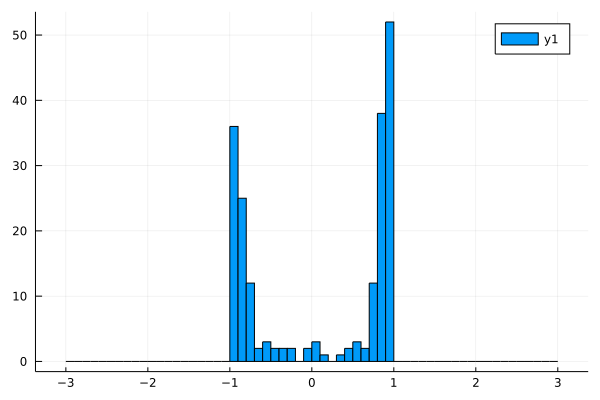

In [98]:
histogram(Alpha[:,1], bins = -3:0.1:3)

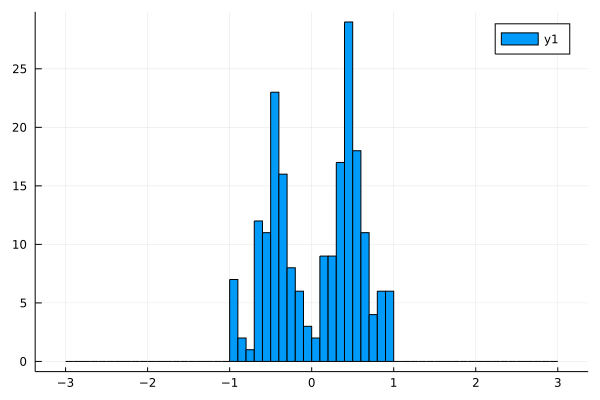

In [99]:
histogram(Alpha[:,2], bins = -3:0.1:3)

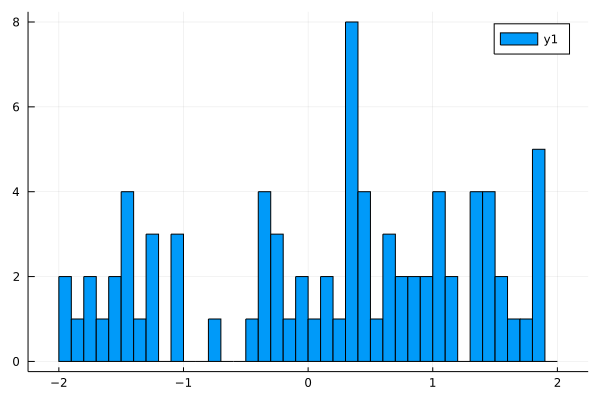

In [101]:
histogram(Beta[:, 2], bins = -2:0.1:2)

In [104]:
Rb = kmeans(transpose(Theta), 1)
Rb.centers

2×1 Array{Float64,2}:
  2.9660105030895365
 -0.8281085806499097

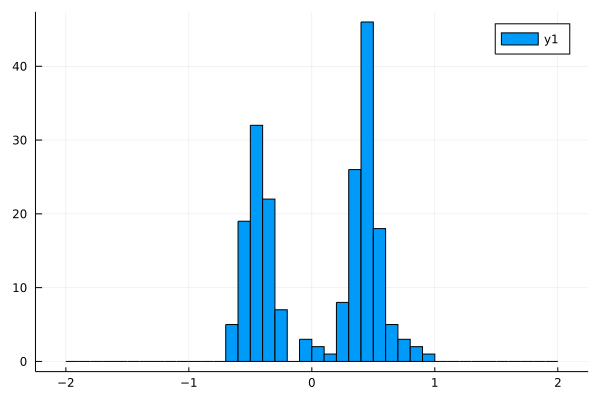

In [95]:
histogram(Gamma[:,1], bins = -2:0.1:2)

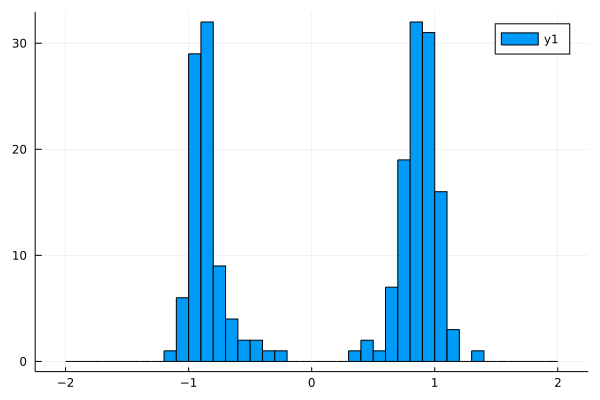

In [96]:
histogram(Gamma[:,2], bins = -2:0.1:2)

In [97]:
Rg = kmeans(transpose(Gamma), 2)
Rg.centers

2×2 Array{Float64,2}:
 0.44421   -0.43239
 0.872398  -0.850241

In [89]:
mean(abs.(Gamma), dims = 1)

1×2 Array{Float64,2}:
 0.441529  0.86276

In [88]:
mean(abs.(Alpha), dims = 1)

1×2 Array{Float64,2}:
 0.827373  0.47976

In [26]:
ind1 = Rg.assignments .== 1
ind2 = Rg.assignments .== 2
v1 = var(Gamma[ind1, :], dims = 1)

1×2 Array{Float64,2}:
 0.102972  0.0606612

In [27]:
len1 = sum(ind1) - 1
len2 = sum(ind2) - 1

102

In [62]:
mean(Gamma[ind2, :], dims = 1)

1×2 Array{Float64,2}:
 -0.0869934  -0.196478

In [63]:
v2 = var(Gamma[ind2, :], dims = 1)

1×2 Array{Float64,2}:
 0.205616  0.804259

In [64]:
(v1 * len1 + v2* len2) /(len - 1)

1×2 Array{Float64,2}:
 0.155066  0.441497

In [30]:
var(abs.(Gamma), dims = 1)

1×2 Array{Float64,2}:
 0.0846077  0.0498892

In [78]:
Ra= kmeans(transpose(Alpha), 2)
Ra.centers

2×2 Array{Float64,2}:
 -0.851125  0.788011
 -0.403674  0.412675

In [351]:
using DataFrames
df = DataFrame(α1 = Float64[], α2 = Float64[],
               var_α1 = Float64[], var_α2 = Float64[],    
               θ1 = Float64[], θ2 = Float64[],
               var_θ1 = Float64[], var_θ2 = Float64[], 
               β1 = Float64[], β2 = Float64[],
               var_β1 = Float64[], var_β2 = Float64[], 
               γ1 = Float64[], γ2 = Float64[],
               var_γ1 = Float64[], var_γ2 = Float64[])


,α1,α2,var_α1,var_α2,θ1,θ2,var_θ1,var_θ2,β1
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64


In [340]:
A = [:α1, :α2, :var_α1, :var_α2]
T = [:θ1, :θ2, :var_θ1, :var_θ2]
G = [:γ1, :γ2, :var_γ1, :var_γ2]
B = [:β1, :β2, :var_β1, :var_β2]

4-element Vector{Symbol}:
 :β1
 :β2
 :var_β1
 :var_β2

In [ ]:
@threads for γ in [[1.0, 0.5], [1.0, 0.001], [0.001, 1.0], [0.5, 1.0],[0.5, 0.5], [0.0001, 0.0001]]
    res, =  MonteCarlo(n, γ, θ, α, β, fx, dist, len, alpha_type)
    push!(df, res)
end